In [1]:
import mdtraj as md
from Bio import PDB

# Load the .cif file using Biopython
parser = PDB.MMCIFParser()
structure = parser.get_structure('NSP13', 'Outputs/fold_wk7_2btf_atp_model_0.cif')

# Save the structure to a .pdb file in memory (if needed)
io = PDB.PDBIO()
io.set_structure(structure)
io.save('Outputs/2btf_atp_af3.pdb')  # Save it as a temporary .pdb file


Number of CA atoms in AF2: 372
Number of CA atoms in AF3: 511


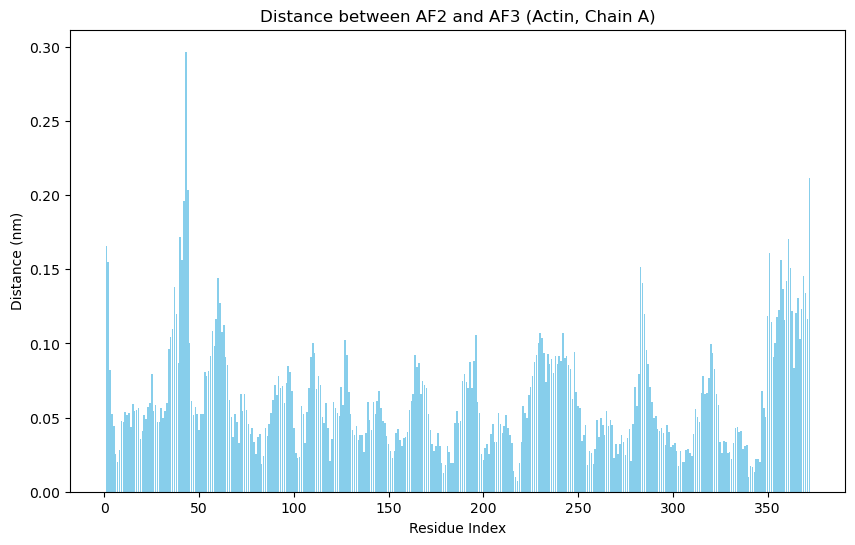

Residues with significant differences (distance > 0.2 nm): [ 43  44 372]
Valid residues near ATP in AF3: [  55   64   65   66   67   68   69   70   72   73   74   75   76   77
   78   79   80   81   82   83   98   99  100  516  517 1045 1167 1170
 1171 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186
 1187 1188 1189 1190 1191 1192 1193 1194 1195 1370 1371 1372 1373 1374
 1375 1376 1407 1604 1605 1606 1607 1629 1630 1634 1635 1636 1637 1638
 1639 1640 1641 1642 1643 1644 2314 2315 2316 2317 2318 2319 2320 2321
 2322 2323 2326 2327 2336 2337 2338 2339 2340 2341 2343 2344 2345 2349
 2350 2351 2352 2353 2354 2355 2579 2581 2582 2583 2584]
Valid residues near Mg2+ in AF3: [  53   54   55   65  100 1044 1045 1046 1165 1166 1167 1175]


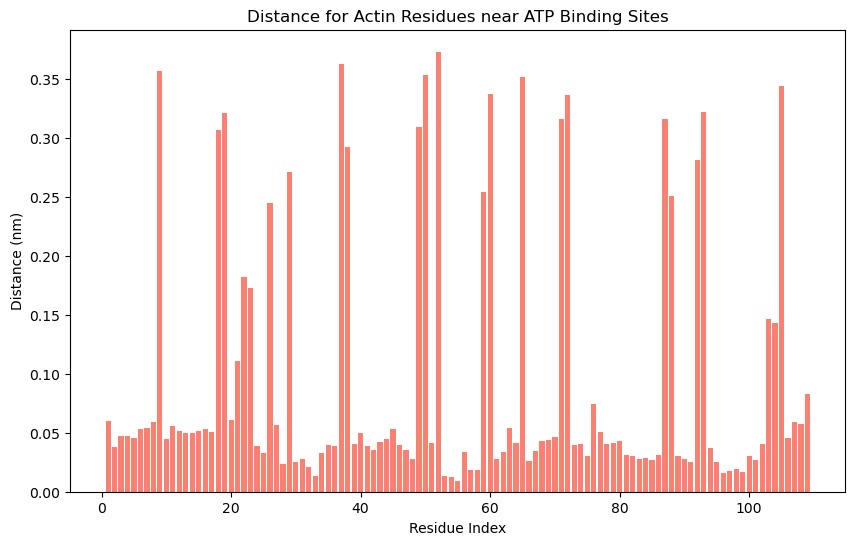

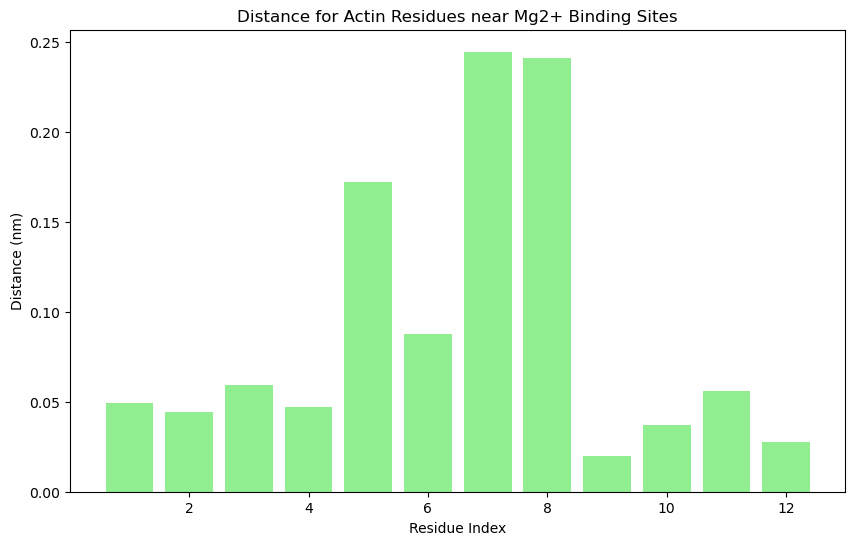

In [21]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the "Images" directory if it doesn't exist
os.makedirs('Images', exist_ok=True)

# Load the AF2 and AF3 predictions (PDB files) with actin (chain A)
af2_traj = md.load('Outputs/2btf_af2.pdb')  # Replace with actual AF2 file path
af3_traj = md.load('Outputs/2btf_atp_af3.pdb')  # Replace with actual AF3 file path (with ATP and Mg2+)

# Select alpha carbon (CA) atoms from chain A in both structures
ca_atoms_af2 = af2_traj.top.select('name CA and chainid 0')  # Chain A in AF2 (Actin)
ca_atoms_af3 = af3_traj.top.select('name CA and chainid 0')  # Chain A in AF3 (Actin)

# Print the number of selected CA atoms for AF2 and AF3
print(f"Number of CA atoms in AF2: {len(ca_atoms_af2)}")
print(f"Number of CA atoms in AF3: {len(ca_atoms_af3)}")

# Handle the mismatch by aligning based on the minimum number of CA atoms
min_atoms = min(len(ca_atoms_af2), len(ca_atoms_af3))
ca_atoms_af2 = ca_atoms_af2[:min_atoms]
ca_atoms_af3 = ca_atoms_af3[:min_atoms]

# Superpose the AF2 structure onto AF3 using the CA atoms
af2_traj.superpose(af3_traj, atom_indices=ca_atoms_af2)

# Calculate the distance between corresponding CA atoms in AF2 and AF3 for each residue
distances = np.linalg.norm(af2_traj.xyz[0, ca_atoms_af2] - af3_traj.xyz[0, ca_atoms_af3], axis=1)

# Plot the distances vs. residue number
residue_indices = np.arange(1, len(distances) + 1)  # Residue indices starting from 1

plt.figure(figsize=(10, 6))
plt.bar(residue_indices, distances, color='skyblue')
plt.xlabel('Residue Index')
plt.ylabel('Distance (nm)')
plt.title('Distance between AF2 and AF3 (Actin, Chain A)')
# Save the figure
plt.savefig('Images/af2_af3_distance_actin_chain_a.png', dpi=300)
plt.show()

# Identify regions with high differences (e.g., distances > 0.2 nm)
significant_differences = np.where(distances > 0.2)[0]
print(f"Residues with significant differences (distance > 0.2 nm): {significant_differences + 1}")  # Adding 1 to match residue index

# Select ATP and Mg2+ residues in AF3
atp_residues_af3 = af3_traj.top.select('resname ATP')  # ATP residues
mg_residues_af3 = af3_traj.top.select('resname MG')    # Mg2+ residues

# Find actin residues near ATP and Mg2+ in AF3
near_atp_residues_af3 = md.compute_neighbors(af3_traj, 0.5, atp_residues_af3)
near_mg_residues_af3 = md.compute_neighbors(af3_traj, 0.5, mg_residues_af3)

# Flatten and remove duplicates
near_atp_residues_af3 = np.unique(np.hstack(near_atp_residues_af3))
near_mg_residues_af3 = np.unique(np.hstack(near_mg_residues_af3))

# Filter to ensure the residue indices exist in AF2
near_atp_residues_af3 = near_atp_residues_af3[near_atp_residues_af3 < af2_traj.n_atoms]
near_mg_residues_af3 = near_mg_residues_af3[near_mg_residues_af3 < af2_traj.n_atoms]

# Print the valid residues near ATP and Mg2+ that exist in both AF2 and AF3
print(f"Valid residues near ATP in AF3: {near_atp_residues_af3}")
print(f"Valid residues near Mg2+ in AF3: {near_mg_residues_af3}")

# Calculate the distances between these residues in AF2 and AF3
distances_near_atp = np.linalg.norm(af2_traj.xyz[0, near_atp_residues_af3] - af3_traj.xyz[0, near_atp_residues_af3], axis=1)
distances_near_mg = np.linalg.norm(af2_traj.xyz[0, near_mg_residues_af3] - af3_traj.xyz[0, near_mg_residues_af3], axis=1)

# Plot ATP-related distance changes
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(distances_near_atp) + 1), distances_near_atp, color='salmon')
plt.xlabel('Residue Index')
plt.ylabel('Distance (nm)')
plt.title('Distance for Actin Residues near ATP Binding Sites')
# Save the figure
plt.savefig('Images/af3_atp_distance_actin.png', dpi=300)
plt.show()

# Plot Mg2+-related distance changes
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(distances_near_mg) + 1), distances_near_mg, color='lightgreen')
plt.xlabel('Residue Index')
plt.ylabel('Distance (nm)')
plt.title('Distance for Actin Residues near Mg2+ Binding Sites')
# Save the figure
plt.savefig('Images/af3_mg_distance_actin.png', dpi=300)
plt.show()
